# SYDE 556/750 --- Assignment 3


In [71]:
# Import numpy and matplotlib -- you shouldn't need any other libraries
import numpy as np
import matplotlib.pyplot as plt

# Fix the numpy random seed for reproducible results
np.random.seed(18945)

# Some formating options
%config InlineBackend.figure_formats = ['svg']

# 1. Decoding from a population

The model we've been working with for a LIF neuron is:

$$
G[J] =
\begin{cases}
\frac{1}{\left( \tau_{\text{ref}} - \tau_{\text{RC}} \right) \ln \left(1 - \frac{1}{J}\right)} & \text{if } J > 1, \\
0 & \text{otherwise}.
\end{cases}
\tag{1}
$$

We also previously derived a relationship between $\alpha$ and $J_{\text{bias}}$ for this LIF neuron model:

$$
J_{\text{bias}} = 1 - \alpha \xi \tag{2}
$$

Re-arranging equation (1), and substituting the encoder equation for $J$, we get:

$$
\alpha \langle \mathbf{e}, \mathbf{x} \rangle + J_{\text{bias}} = \frac{1}{1 - e^{\left( \frac{\tau_{\text{ref}} - \frac{1}{G[J]}}{\tau_{\text{RC}}} \right)}}
\tag{3}
$$

For the population we're modeling, we want the maximum firing rate for each neuron to occur when the input $x$ reaches its radius of 2 for neurons with positive encoders, or -2 for negative encoders.

So, when $\langle \mathbf{e}, \mathbf{x} \rangle=2$, the target $G[J]$ will be $a_{\text{max}}$. Substituting this into (3):

$$
2\alpha + J_{\text{bias}} = \frac{1}{1 - e^{\left( \frac{\tau_{\text{ref}} - \frac{1}{a_{\text{max}}}}{\tau_{\text{RC}}} \right)}}
$$

To solve for $\alpha$, we can substitute expression (2) for $J\_{\text{bias}}$, giving:

$$
2\alpha + 1 - \alpha \xi = \frac{1}{1 - e^{\left( \frac{\tau_{\text{ref}} - \frac{1}{a_{\text{max}}}}{\tau_{\text{RC}}} \right)}}
$$

Which simplifies to:

$$
\alpha = \frac{\frac{1}{1 - e^{\left( \frac{\tau_{\text{ref}} - \frac{1}{a_{\text{max}}}}{\tau_{\text{RC}}} \right)}} - 1}{2-\xi}
$$

Or, for any generic $r$,

$$
\alpha = \frac{\frac{1}{1 - e^{\left( \frac{\tau_{\text{ref}} - \frac{1}{a_{\text{max}}}}{\tau_{\text{RC}}} \right)}} - 1}{r-\xi}
\tag{4}
$$

Equations (1), (2), (4), and the encoding equation are implemented below:


In [72]:
# G(J) for LIF neuron model
def G(J, t_ref, t_RC):
  return np.where(J <= 1, 0, 1 / (t_ref - (t_RC * np.log(np.clip(1 - 1 / J, 1e-10, None)))))

def generate_population_responses(n, x, a_max, xi, e, t_ref, t_RC, r=2):
  # Alpha and J_bias for our LIF neuron model, derived above
  alpha = ( ( 1 / (1 - np.exp(( t_ref - (1 / a_max) ) / t_RC )) ) - 1 ) / ( r - xi )
  J_bias = 1 - alpha * xi

  A = np.zeros((n, len(x)))

  J_vals = []

  for i in range(n):
    # Encoding equation
    J = alpha[i] * np.dot(e[i], x) + J_bias[i]
    J_vals.append(J)
    A[i, :] = G(J, t_ref, t_RC)
  
  return A, np.array(J_vals), alpha, J_bias

**a) Tuning curves.** Plot the tuning curves (firing rate of each neuron for different $x$ values between $-2$ and $2$).


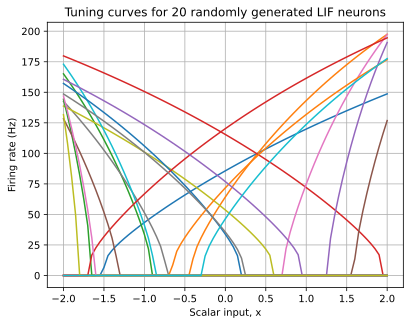

In [73]:
n = 20 # 20 neurons
N = 81 # Choosing 0.05 step increments for x

# Time constants
t_ref = 0.002
t_RC = 0.02

# Max firing rates and intercepts
a_max = np.random.uniform(100, 200, n)
xi = np.random.uniform(-2, 2, n)

# Encoders are -1 or 1, <x, e> = r = 2 for max firing
e = np.random.choice([-1, 1], size=n)

# Input value x, with radius r=2
x = np.linspace(-2, 2, N)

A, _, alpha, J_bias = generate_population_responses(n, x, a_max, xi, e, t_ref, t_RC)

# Plot response curves
plt.figure()
for i in range(n):
  plt.plot(x, A[i])

plt.ylabel("Firing rate (Hz)")
plt.xlabel("Scalar input, x")
plt.title("Tuning curves for 20 randomly generated LIF neurons")
plt.grid(True)
plt.show()


**b) Decoder and error computation.** Compute the decoders and plot $(x-\hat{x})$. When computing decoders, take into account noise ($\sigma=0.1 \cdot 200\,\mathrm{Hz}$). When computing $\hat{x}$, add random Gaussian noise with $\sigma=0.1 \cdot 200\,\mathrm{Hz}$ to the activity. Report the Root Mean-Squared Error (RMSE).


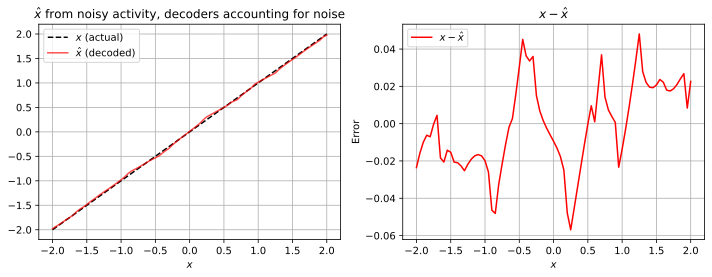

RMSE: 0.023



In [74]:
# Standard deviation
sigma = 0.1 * 200

# Decoders accounting for random Gaussian noise
D = np.linalg.lstsq(A @ A.T + A.shape[1] * np.square(sigma) * np.eye(n), A @ x.T, rcond=None)[0].T

# Also add random Gaussian noise to activities for decoding
A_noisy = A + np.random.normal(0, sigma, A.shape)

x_hat = (D @ A).T

plt.figure(figsize=(10, 4))

# Plotting x vs. x_hat
plt.subplot(1, 2, 1)
plt.plot(x, x, label="$x$ (actual)", linestyle='--', color='black')
plt.plot(x, x_hat, label="$\hat{x}$ (decoded)", color='red', alpha=0.7)
plt.title("$\hat{x}$ from noisy activity, decoders accounting for noise")
plt.xlabel("$x$")
plt.grid(True)
plt.legend()

# Plot the error
plt.subplot(1, 2, 2)
plt.plot(x, x - x_hat, label="$x - \hat{x}$", color="red")
plt.title("$x - \hat{x}$")  
plt.xlabel("$x$") 
plt.ylabel("Error")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Report RMSE
RMSE = np.sqrt(np.mean((x - x_hat.flatten()) ** 2))
print(f"RMSE: {RMSE:.3f}\n")

# 2. Decoding from two spiking neurons


Re-using functions from Assignment 2 for:

1. Generating a random band-limited input signal, $x(t)$
2. Calculating $dv/dt$ with Euler's method
3. Getting spike trains for two neurons, positive and negative, based on their spike times
4. Manually convolving two time-domain signals together


In [75]:
def generate_limit_signal(T, dt, rms, limit, seed):
    np.random.seed(seed)
    
    N = int(T / dt)
    f = np.fft.fftfreq(N, dt)

    X = np.zeros(N, dtype=complex)

    # Fill in X(w) samples for given frequency limit
    for i in range(N):
        if abs(f[i]) <= limit:
            # Randomly generate Fourier coefficients from normal distribution
            a = np.random.normal(0, 1)
            b = np.random.normal(0, 1)
            X[i] = a + b * 1j

    # Ensuring Hermitian symmetry for inverse fourier transform will ensure time signal is purely real
    X[N // 2 + 1:] = np.conj(X[1:N // 2][::-1])

    x = np.fft.ifft(X).real

    # Scale to desired RMS from current RMS
    scale = rms / np.sqrt(np.mean(x ** 2))
    x *= scale
    X = np.fft.fft(x)
    
    return x, X

def dv_dt(T, dt, J_input, v_th, t_ref, t_RC):
    v_vals = []  # to record v over time

    t_spikes = []  # to record spike times
    v_spikes = []  # to record v reached at spikes, just for plotting

    t = 0  # current time
    v = 0  # current v

    time_steps = int(T/dt)

    refractory_time = 0  # track time spent in refractory period

    # Euler's method: loop through time span getting v by incrementing previous v using dv
    for i in range(time_steps):
        # set v to zero while in refractory period
        if refractory_time > 0:
            v = 0
            refractory_time -= dt
        else:
            dv = (1 / t_RC) * (J_input[i] - v)
            v += dv * dt

            # Enforce v=0
            if v < 0:
                v = 0

            # if spiked, record time & enter refractory period
            if v >= v_th:
                t_spikes.append(t)
                v_spikes.append(v)
                refractory_time = t_ref
        
        v_vals.append(v)
        t += dt
    
    # Return values for plotting, spike times
    return v_vals, t_spikes, v_spikes

# Get the spike trains for two neurons, positive and negative
def get_spike_trains(T, dt, t_spikes_1, t_spikes_2):
    t = np.arange(0, T, dt)
    spikes_1 = np.zeros_like(t)
    spikes_2 = np.zeros_like(t)

    for t_spike in t_spikes_1:
        # Add a small tolerance for floating point error when placing spike times in t
        spike_idx = np.where(np.isclose(t, t_spike, atol=dt/2))[0]
        if len(spike_idx) > 0:
            spikes_1[spike_idx[0]] = 1 

    for t_spike in t_spikes_2:
        spike_idx = np.where(np.isclose(t, t_spike, atol=dt/2))[0]
        if len(spike_idx) > 0:
            spikes_2[spike_idx[0]] = 1

    return np.array([spikes_1, spikes_2])

def convolve(r, h):
    spikes_convolve_h = np.zeros_like(r)

    # At each spike
    for t in range(len(r)):
        if r[t] != 0: 
            # Apply h(t) starting from each time t
            end_idx = min(t + len(h), len(spikes_convolve_h))
            spikes_convolve_h[t:end_idx] += r[t] * h[:end_idx - t]

    return spikes_convolve_h

Generate $x(t)$, the two desired neurons, and their spike responses to $x(t)$:


In [76]:
# Index where x = 0 in previous population
target_x = np.where(x == 0)[0] # = 40 since N = 81

# Target neuron that hits a firing rate between 20 and 50Hz for x = 0 from prev. population
target_neuron = np.where((A[:, target_x] >= 20) & (A[:, target_x] <= 50))[0][0]

# Get its alpha and J_bias (returned in generate_population_responses)
alpha_target = alpha[target_neuron]
J_bias_target = J_bias[target_neuron]

# Define parameters needed for spikes, let v_th = 1.0
T = 1
dt = 0.001
t = np.arange(0, T, dt)
v_th = 1.0

# Generate input signal
x_t, X_u = generate_limit_signal(T, dt, rms=1, limit=5, seed=5346)

# Spikes for target neuron 1, encoder -1
J_1 = alpha_target * np.dot(-1, x_t) + J_bias_target
v_vals_1, t_spikes_1, v_spikes_1 = dv_dt(T, dt, J_1, v_th, t_ref, t_RC)

# Spikes for target neuron 2, encoder 1
J_2 = alpha_target * np.dot(1, x_t) + J_bias_target
v_vals_2, t_spikes_2, v_spikes_2 = dv_dt(T, dt, J_2, v_th, t_ref, t_RC)


**a) Synaptic filter.** Plot the post-synaptic current

$$
			h(t)= \begin{cases}
				0 & \text{if } t < 0 \,, \\
				\frac{e^{-t/\tau}}{\int_0^\infty e^{-t'/\tau} \mathrm{d}t'} & \text{otherwise} \,.
			\end{cases}


$$

Using the analytical solution for the integral to code $h(t)$:


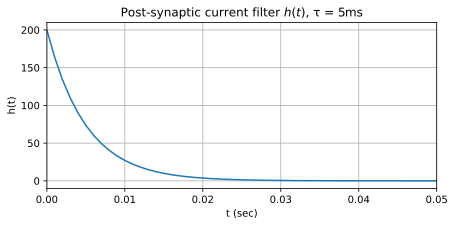

In [77]:
def h(t, tau):
    h = np.where(t < 0, 0, (1 / tau) * np.exp(-t / tau))
    return h

# h(t) for given tau
h_t = h(t, tau=0.005)

plt.figure(figsize=(7, 3))
plt.plot(t, h_t)
plt.title("Post-synaptic current filter $h(t)$, τ = 5ms")
plt.xlabel("t (sec)")
plt.ylabel("h(t)")
plt.xlim([0, 0.05])
plt.grid(True)
plt.show()

**b) Decoding using a synaptic filter.** Plot the original signal $x(t)$, the spikes, and the decoded $\hat{x}(t)$ all on the same graph.


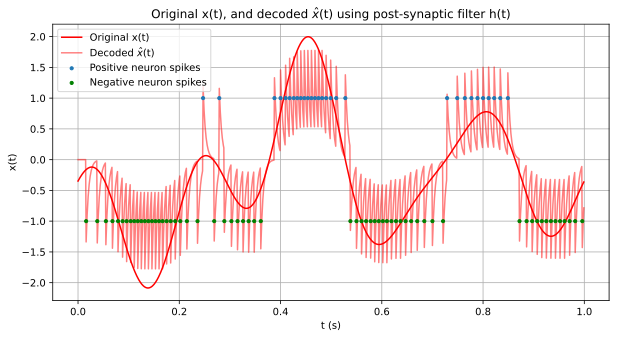

In [78]:
# Get the spike trains
spikes = get_spike_trains(T, dt, t_spikes_1, t_spikes_2)

# Spike train difference for two neurons
r = spikes[0] - spikes[1]

# Apply synaptic filter h_t
A = (convolve(r, h_t)).reshape(1, -1)

# Compute decoders, accounting for noise
D = np.linalg.lstsq(A @ A.T + A.shape[1] * np.square(sigma) * np.eye(A.shape[0]), A @ x_t.T, rcond=None)[0].T

# Decode x_hat
x_hat = (D  @ A).T

plt.figure(figsize=(10,5))
plt.title('Original x(t), and decoded $\hat{x}$(t) using post-synaptic filter h(t)')
plt.plot(t, x_t, label="Original x(t)", color='red')
plt.plot(t, x_hat, label="Decoded $\hat{x}$(t)", color='red', alpha=0.5)
plt.scatter(t[spikes[1] == 1], spikes[1][spikes[1] == 1], label='Positive neuron spikes', s=10, zorder=3)
plt.scatter(t[spikes[0] == 1], -1 * spikes[0][spikes[0] == 1], label='Negative neuron spikes', s=10, color='green', zorder=3)
plt.xlabel('t (s)')
plt.ylabel('x(t)')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

**c) Error analysis.** Compute the RMSE of the decoding.


In [79]:
RMSE = np.sqrt(np.mean((x_t - x_hat) ** 2))
print(f"RMSE: {RMSE:.3f}\n")

RMSE: 0.565



# 3. Decoding from many neurons


**a) Exploring the error for an increasing neuron count.** Plot the Root Mean-Squared Error as the number of neurons increases, on a log-log plot. Try $8$ neurons, $16$ neurons, $32$, $64$, $128$, up to $256$. For the RMSE for a particular number of neurons, average over at least $5$ randomly generated groups of neurons. For each group of neurons, randomly generate the signal $x(t)$. Use the same parameters as in question 2.


RMSE for 8 neurons: 0.435
RMSE for 16 neurons: 0.308
RMSE for 32 neurons: 0.223
RMSE for 64 neurons: 0.175
RMSE for 128 neurons: 0.133
RMSE for 256 neurons: 0.102


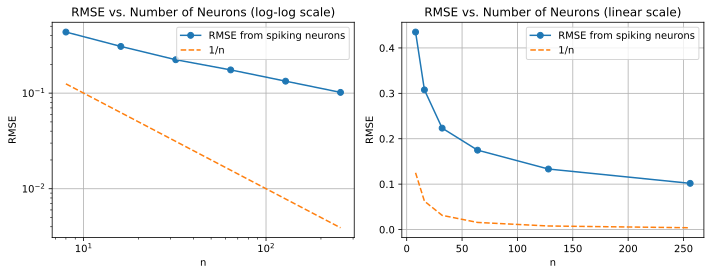

In [80]:
avg_rmses = []

# 8, 16, ..., 256
neuron_counts = [pow(2, i) for i in range(3, 9)]

for n in neuron_counts:
    # For different numbers of neurons
    rmses = []
    
    # Averaging over 5 groups of neurons
    for g in range(5):
        # Generate parameters & current J
        a_max = np.random.uniform(100, 200, n)
        xi = np.random.uniform(-2, 2, n)
        e = np.random.choice([-1, 1], size=n)

        # New random signal for each group of neurons
        x_t, _ = generate_limit_signal(T, dt, rms=1, limit=5, seed=n*(g+1))

        _, J, _, _ = generate_population_responses(n, x_t, a_max, xi, e, t_ref, t_RC)
        
        spike_trains = np.zeros_like(J)
        
        # Calcualte dv/dt for each neuron
        for i in range(n):
            v_vals, t_spikes, _ = dv_dt(T, dt, J[i], v_th, t_ref, t_RC)
            
            # Store spike trains for each neuron
            spike_trains[i] = get_spike_trains(T, dt, t_spikes, [])[0]
        
        # Apply post-synaptic filter
        A = np.array([convolve(spike_train, h_t) for spike_train in spike_trains])

        # Decode x_hat
        D = np.linalg.lstsq(A @ A.T + A.shape[1] * np.square(sigma) * np.eye(A.shape[0]), A @ x_t.T, rcond=None)[0]
        x_hat = D @ A

        # RMSE
        rmse = np.sqrt(np.mean((x_t - x_hat) ** 2))
        rmses.append(rmse)
    
    avg_rmses.append(np.mean(rmses))

for i in range(len(avg_rmses)):
    print(f"RMSE for {neuron_counts[i]} neurons: {avg_rmses[i]:.3f}")

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# loglog plot
ax[0].loglog(neuron_counts, avg_rmses, marker='o', label="RMSE from spiking neurons")
ax[0].loglog(neuron_counts, [1/n for n in neuron_counts], linestyle='--', label='1/n')
ax[0].set_xlabel("n")
ax[0].set_ylabel("RMSE")
ax[0].set_title("RMSE vs. Number of Neurons (log-log scale)")
ax[0].grid(True)
ax[0].legend()

# normal plot for reference
ax[1].plot(neuron_counts, avg_rmses, marker='o', label="RMSE from spiking neurons")
ax[1].plot(neuron_counts, [1/n for n in neuron_counts], linestyle='--', label='1/n')
ax[1].set_xlabel("n")
ax[1].set_ylabel("RMSE")
ax[1].set_title("RMSE vs. Number of Neurons (linear scale)")
ax[1].grid(True)
ax[1].legend()

plt.tight_layout()
plt.show()

**b) Discussion.** Discuss your results. What is the systematic relationship between the neuron count and the error?


The RMSE decreases as the number of neurons increases. The change in error is proportional to $\frac{1}{n}$. Plotting $\frac{1}{n}$ side-by-side with the RMSE on both a log-log and linear scale demonstrates this relationship. The more neurons we have, the wider range of responses to input $x(t)$ we'll have in our population, and therefore be able to capture the relationship between neuron activities and $x(t)$ more accurately in our decoders, leading to less error. In other words, as $n$ increases, the closer to 0 our error gets, proportional to $\frac{1}{n}$.


# 4. Connecting two groups of neurons


First, computing the decoders for $f(x)=2x+1$, and $f(y)=y$, for generic inputs across the space:


In [81]:
def f(x):
    return 2 * x + 1

n = 200

# Parameters for population x
a_max_x = np.random.uniform(100, 200, n)
xi_x = np.random.uniform(-1, 1, n)
e_x = np.random.choice([-1, 1], size=n)

# Parameters for population y
a_max_y = np.random.uniform(100, 200, n)
xi_y = np.random.uniform(-1, 1, n)
e_y = np.random.choice([-1, 1], size=n)

# Start with generic training x input to get f(x) = 2x + 1 decoders
x_train = np.linspace(-1, 1, len(t))
f_x_train = f(x_train)

# Population x activities, in response to training x
A_x_train, _, _, _ = generate_population_responses(n, x_train, a_max_x, xi_x, e_x, t_ref, t_RC, r=1)

# Decoders for f(x) = 2x + 1, based on generic training input x that spans entire radius
D_fx = np.linalg.lstsq(
    A_x_train @ A_x_train.T + A_x_train.shape[1] * np.square(sigma) * np.eye(n), 
    A_x_train @ f_x_train, 
    rcond=None
)[0]

# Now, generic training y input to get f(y) = y decoders
y_train = np.linspace(-1, 1, len(t))
f_y_train = y_train

A_y_train, _, _, _ = generate_population_responses(n, y_train, a_max_y, xi_y, e_y, t_ref, t_RC, r=1)

# Decoders for f(y) = y
D_fy = np.linalg.lstsq(
    A_y_train @ A_y_train.T + A_y_train.shape[1] * np.square(sigma) + np.eye(n),
    A_y_train @ f_y_train, 
    rcond=None
)[0]

**a) Computing a function.** Show the behaviour of the system with an input of $x(t)=t-1$ for $1\,\mathrm{s}$ (a linear ramp from $-1$ to $0$). Plot the ideal $x(t)$ and $y(t)$ values, along with $\hat{y}(t)$.


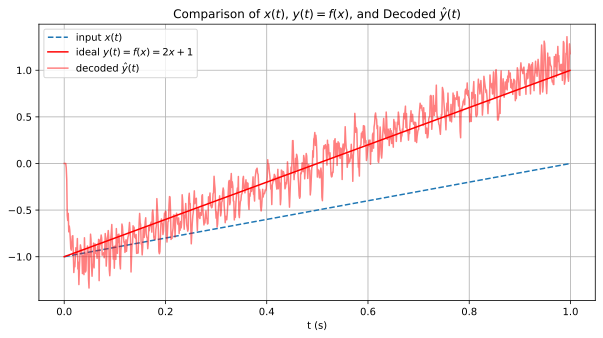

In [82]:
# Using previous t, spanning 1.0s
x_t = t - 1
y_t = f(x_t)

# Input x_t into population x, get spike trains
_, J_x, _, _ = generate_population_responses(n, x_t, a_max_x, xi_x, e_x, t_ref, t_RC, r=1)

spike_trains_x = np.zeros_like(J_x)

for i in range(n):
    _, t_spikes, _ = dv_dt(T, dt, J_x[i], v_th, t_ref, t_RC)
    spike_trains_x[i] = get_spike_trains(T, dt, t_spikes, [])[0]

# Apply post-synaptic filter, h(t), to resulting spike trains
A_fx = np.array([convolve(spike_train, h_t) for spike_train in spike_trains_x])

# Decode f(x) with decoders
f_x_hat = D_fx @ A_fx

# Feed decoded f(x) into population y, get spikes
_, J_y, _, _ = generate_population_responses(n, f_x_hat, a_max_y, xi_y, e_y, t_ref, t_RC, r=1)

spike_trains_y = np.zeros_like(J_y)

for i in range(n):
    _, t_spikes, _ = dv_dt(T, dt, J_y[i], v_th, t_ref, t_RC)
    spike_trains_y[i] = get_spike_trains(T, dt, t_spikes, [])[0]

# Apply synaptic filter and decode f(y) = y
A_fy = np.array([convolve(spike_train, h_t) for spike_train in spike_trains_y])

f_y_hat = D_fy @ A_fy

# Plot y_hat(t), x(t), y(t)
plt.figure(figsize=(10, 5))

plt.plot(t, x_t, label="input $x(t)$", linestyle="--")
plt.plot(t, y_t, label="ideal $y(t) = f(x) = 2x + 1$", color="red")
plt.plot(t, f_y_hat, label="decoded $\hat{y}(t)$", color="red", alpha=0.5)

plt.xlabel("t (s)")
plt.title("Comparison of $x(t)$, $y(t) = f(x)$, and Decoded $\hat{y}(t)$")
plt.legend()
plt.grid(True)
plt.show()

**b) Step input.** Repeat part (a) with an input that is ten randomly chosen values between -1 and 0, each one held for 0.1 seconds (a randomly varying step input)


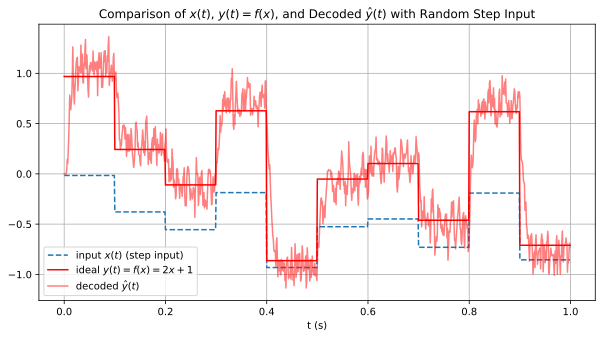

In [83]:
# Step input x(t), 10 random values between -1 and 0, repeat each for 0.1s
step_values = np.random.uniform(-1, 0, 10) 
x_t = np.repeat(step_values, len(t) // 10)
y_t = f(x_t)

# Input x_t into population x, get spike trains
_, J_x, _, _ = generate_population_responses(n, x_t, a_max_x, xi_x, e_x, t_ref, t_RC, r=1)

spike_trains_x = np.zeros_like(J_x)

for i in range(n):
    _, t_spikes, _ = dv_dt(T, dt, J_x[i], v_th, t_ref, t_RC)
    spike_trains_x[i] = get_spike_trains(T, dt, t_spikes, [])[0]

# Apply post-synaptic filter, h(t)
A_fx = np.array([convolve(spike_train, h_t) for spike_train in spike_trains_x])

# Decode f(x) with decoders
f_x_hat = D_fx @ A_fx

# Feed decoded f(x) into population y, get spikes
_, J_y, _, _ = generate_population_responses(n, f_x_hat, a_max_y, xi_y, e_y, t_ref, t_RC, r=1)

spike_trains_y = np.zeros_like(J_y)

for i in range(n):
    _, t_spikes, _ = dv_dt(T, dt, J_y[i], v_th, t_ref, t_RC)
    spike_trains_y[i] = get_spike_trains(T, dt, t_spikes, [])[0]

# Apply synaptic filter and decode f(y) = y
A_fy = np.array([convolve(spike_train, h_t) for spike_train in spike_trains_y])
f_y_hat = D_fy @ A_fy

# Plot y_hat(t), x(t), y(t) for step input
plt.figure(figsize=(10, 5))

plt.plot(t, x_t, label="input $x(t)$ (step input)", linestyle="--")
plt.plot(t, y_t, label="ideal $y(t) = f(x) = 2x + 1$", color="red")
plt.plot(t, f_y_hat, label="decoded $\hat{y}(t)$", color="red", alpha=0.5)

plt.xlabel("t (s)")
plt.title("Comparison of $x(t)$, $y(t) = f(x)$, and Decoded $\hat{y}(t)$ with Random Step Input")
plt.legend()
plt.grid(True)
plt.show()


**c) Sinusoidal input.** Repeat part (a) with an input that is $x(t)=0.2\sin(6\pi t)$.


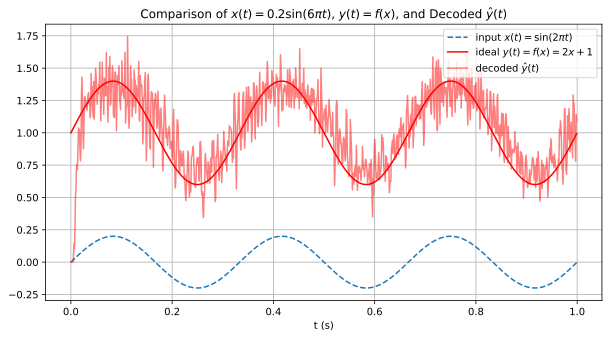

In [84]:
x_t = 0.2 * np.sin(6 * np.pi * t)
y_t = f(x_t)

_, J_x, _, _ = generate_population_responses(n, x_t, a_max_x, xi_x, e_x, t_ref, t_RC, r=1)

spike_trains_x = np.zeros_like(J_x)

for i in range(n):
    _, t_spikes, _ = dv_dt(T, dt, J_x[i], v_th, t_ref, t_RC)
    spike_trains_x[i] = get_spike_trains(T, dt, t_spikes, [])[0]

A_fx = np.array([convolve(spike_train, h_t) for spike_train in spike_trains_x])
f_x_hat = D_fx @ A_fx

_, J_y, _, _ = generate_population_responses(n, f_x_hat, a_max_y, xi_y, e_y, t_ref, t_RC, r=1)

spike_trains_y = np.zeros_like(J_y)

for i in range(n):
    _, t_spikes, _ = dv_dt(T, dt, J_y[i], v_th, t_ref, t_RC)
    spike_trains_y[i] = get_spike_trains(T, dt, t_spikes, [])[0]

A_fy = np.array([convolve(spike_train, h_t) for spike_train in spike_trains_y])
f_y_hat = D_fy @ A_fy

# Plot y_hat(t), x(t), y(t) for the sinusoidal input
plt.figure(figsize=(10, 5))

plt.plot(t, x_t, label="input $x(t) = \sin(2\pi t)$", linestyle="--")
plt.plot(t, y_t, label="ideal $y(t) = f(x) = 2x + 1$", color="red")
plt.plot(t, f_y_hat, label="decoded $\hat{y}(t)$", color="red", alpha=0.5)

plt.xlabel("t (s)")
plt.title("Comparison of $x(t) = 0.2\sin(6\pi t)$, $y(t) = f(x)$, and Decoded $\hat{y}(t)$")
plt.legend()
plt.grid(True)
plt.show()


**d) Discussion.** Briefly discuss the results for this question. Does the output match the ideal output? What kind of deviations do you see and why do those exist?


The decoded output tracks the position of the ideal input, but with lots of noticeable fluctuation. However, since we're now working with 200 neurons, our decoded output looks significantly better than it did in Question 2 when using only two neurons, since we're able to capture more responses to various inputs. This is also backed up by our results from Question 3 - decoding with more neurons leads to less error proportionately.

We still see fluctuations for several reasons. One is that decoding with spikes is inherently noisy. Even when we apply a smoothing filter, spike trains are very abrupt. We're attempting to capture continuous functions with a finite collection of impulses. Since neurons naturally have spiking behaviour, and operate in noisy conditions, it'll always be difficult to perfectly capture the functions between populations, despite adding a regularization term to our decoders.

Synaptic filtering can also play a role in causing deviations from the ideal output. Although filtering helps us smooth out the spike responses, it comes at the cost of causing slight delays in the decoded response. It also smooths away high-frequency (or high-detail) parts of the output. This is particularly noticeable with the step input decoding. It's hard for the spikes to capture the abrupt changes, because h(t) naturally smooths away these high-frequency, sudden differences. Neurons also have a refractory period, which adds more difficulty to capturing very sudden changes in the input function. Because of this, the abrupt changes in the step input look almost linear in the approximated output.


# 5. Connecting three groups of neurons


Start by computing decoders for $f(x)=0.5x$, $f(y)=2y$, and $z$, for generic inputs across each space:


In [85]:
def fx(x):
    return 0.5 * x

def fy(y):
    return 2 * y

n = 200

# Population x parameters
a_max_x = np.random.uniform(100, 200, n)
xi_x = np.random.uniform(-1, 1, n)
e_x = np.random.choice([-1, 1], size=n)

# Population y parameters
a_max_y = np.random.uniform(100, 200, n)
xi_y = np.random.uniform(-1, 1, n)
e_y = np.random.choice([-1, 1], size=n)

# Population z parameters
a_max_z = np.random.uniform(100, 200, n)
xi_z = np.random.uniform(-1, 1, n)
e_z = np.random.choice([-1, 1], size=n)

# Decoders D_fx, for f(x) = 0.5x
x_train = np.linspace(-1, 1, len(t))
f_x_train = fx(x_train)
A_x_train, _, _, _ = generate_population_responses(n, x_train, a_max_x, xi_x, e_x, t_ref, t_RC, r=1)

D_fx = np.linalg.lstsq(
    A_x_train @ A_x_train.T + A_x_train.shape[1] * np.square(sigma) * np.eye(n), 
    A_x_train @ f_x_train, 
    rcond=None
)[0]

# Decoders D_fy, for f(y) = 2y
y_train = np.linspace(-1, 1, len(t))
f_y_train = fy(y_train)
A_y_train, _, _, _ = generate_population_responses(n, y_train, a_max_y, xi_y, e_y, t_ref, t_RC, r=1)

D_fy = np.linalg.lstsq(
    A_y_train @ A_y_train.T + A_y_train.shape[1] * np.square(sigma) + np.eye(n),
    A_y_train @ f_y_train, 
    rcond=None
)[0]

# Decoders D_z, for z
z_train = np.linspace(-1, 1, len(t))
A_z_train, _, _, _ = generate_population_responses(n, z_train, a_max_z, xi_z, e_z, t_ref, t_RC, r=1)

D_z = np.linalg.lstsq(
    A_z_train @ A_z_train.T + A_z_train.shape[1] + np.square(sigma) + np.eye(n),
    A_z_train @ z_train,
    rcond=None
)[0]

**a) Sinusoidal input.** Plot $x(t)$, $y(t)$, the ideal $z(t)$, and the decoded $\hat{z}(t)$ for an input of $x(t)=\cos(3\pi t)$ and $y(t)=0.5 \sin (2 \pi t)$ (over $1\,\mathrm{s}$).


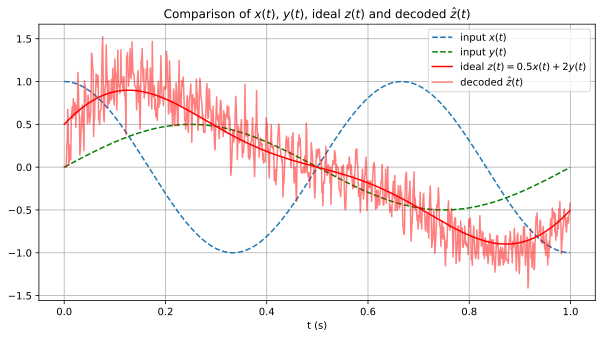

In [86]:
x_t = np.cos(3 * np.pi * t)
y_t = 0.5 * np.sin(2 * np.pi * t)
z_t = fx(x_t) + fy(y_t)

# Feed x(t) into population x
_, J_x, _, _ = generate_population_responses(n, x_t, a_max_x, xi_x, e_x, t_ref, t_RC, r=1)

spike_trains_x = np.zeros_like(J_x)

for i in range(n):
    _, t_spikes, _ = dv_dt(T, dt, J_x[i], v_th, t_ref, t_RC)
    spike_trains_x[i] = get_spike_trains(T, dt, t_spikes, [])[0]

# Decode 0.5x
A_fx = np.array([convolve(spike_train, h_t) for spike_train in spike_trains_x])
f_x_hat = D_fx @ A_fx

# Feed y(t) into population y
_, J_y, _, _ = generate_population_responses(n, y_t, a_max_y, xi_y, e_y, t_ref, t_RC, r=1)

spike_trains_y = np.zeros_like(J_y)

for i in range(n):
    _, t_spikes, _ = dv_dt(T, dt, J_y[i], v_th, t_ref, t_RC)
    spike_trains_y[i] = get_spike_trains(T, dt, t_spikes, [])[0]

# Decode 2y
A_fy = np.array([convolve(spike_train, h_t) for spike_train in spike_trains_y])
f_y_hat = D_fy @ A_fy

# Add decoded 0.5x + 2y, feed into population z
z_input = f_x_hat + f_y_hat
_, J_z, _, _ = generate_population_responses(n, z_input, a_max_z, xi_z, e_z, t_ref, t_RC, r=1)

spike_trains_z = np.zeros_like(J_z)

for i in range(n):
    _, t_spikes, _ = dv_dt(T, dt, J_z[i], v_th, t_ref, t_RC)
    spike_trains_z[i] = get_spike_trains(T, dt, t_spikes, [])[0]

# Decode z
A_z = np.array([convolve(spike_train, h_t) for spike_train in spike_trains_z])
z_hat = D_z @ A_z

# Plot y_hat(t), x(t), y(t)
plt.figure(figsize=(10, 5))

plt.plot(t, x_t, label="input $x(t)$", linestyle="--")
plt.plot(t, y_t, label="input $y(t)$", linestyle="--", color='green')
plt.plot(t, z_t, label="ideal $z(t)=0.5x(t)+2y(t)$", color='red')
plt.plot(t, z_hat, label="decoded $\hat{z}(t)$", color='red', alpha=0.5)

plt.xlabel("t (s)")
plt.title("Comparison of $x(t)$, $y(t)$, ideal $z(t)$ and decoded $\hat{z}(t)$")
plt.legend()
plt.grid(True)
plt.show()

**b) Random input.** Plot $x(t)$, $y(t)$, the ideal $z(t)$, and the decoded $\hat{z}(t)$ for a random input over $1\,\mathrm{s}$. For $x(t)$ use a random signal with a limit of $8\,\mathrm{Hz}$ and $\mathtt{rms}=1$. For $y(t)$ use a random signal with a limit of $5\,\mathrm{Hz}$ and $\mathtt{rms}=0.5$.


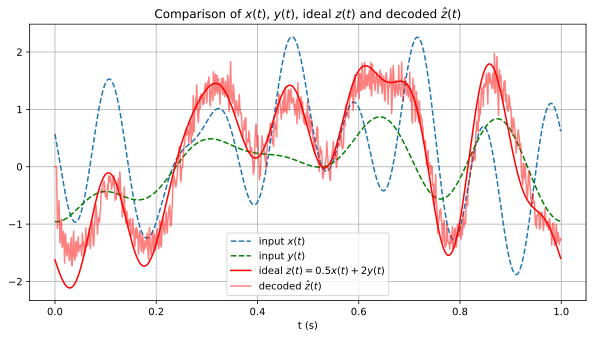

In [87]:
x_t, _ = generate_limit_signal(T, dt, rms=1, limit=8, seed=98435)
y_t, _ = generate_limit_signal(T, dt, rms=0.5, limit=5, seed=32904)
z_t = fx(np.array(x_t)) + fy(np.array(y_t))

# Feed x(t) into population x
_, J_x, _, _ = generate_population_responses(n, x_t, a_max_x, xi_x, e_x, t_ref, t_RC, r=1)

spike_trains_x = np.zeros_like(J_x)

for i in range(n):
    _, t_spikes, _ = dv_dt(T, dt, J_x[i], v_th, t_ref, t_RC)
    spike_trains_x[i] = get_spike_trains(T, dt, t_spikes, [])[0]

# Decode x(t)
A_fx = np.array([convolve(spike_train, h_t) for spike_train in spike_trains_x])
f_x_hat = D_fx @ A_fx

# Feed y(t) into population y
_, J_y, _, _ = generate_population_responses(n, y_t, a_max_y, xi_y, e_y, t_ref, t_RC, r=1)

spike_trains_y = np.zeros_like(J_y)

for i in range(n):
    _, t_spikes, _ = dv_dt(T, dt, J_y[i], v_th, t_ref, t_RC)
    spike_trains_y[i] = get_spike_trains(T, dt, t_spikes, [])[0]

# Decode y(t)
A_fy = np.array([convolve(spike_train, h_t) for spike_train in spike_trains_y])
f_y_hat = D_fy @ A_fy

# Add decoded 0.5x + 2y, feed into population z
z_input = f_x_hat + f_y_hat
_, J_z, _, _ = generate_population_responses(n, z_input, a_max_z, xi_z, e_z, t_ref, t_RC, r=1)

spike_trains_z = np.zeros_like(J_z)

for i in range(n):
    _, t_spikes, _ = dv_dt(T, dt, J_z[i], v_th, t_ref, t_RC)
    spike_trains_z[i] = get_spike_trains(T, dt, t_spikes, [])[0]

# Decode z
A_z = np.array([convolve(spike_train, h_t) for spike_train in spike_trains_z])
z_hat = D_z @ A_z

# Plot y_hat(t), x(t), y(t)
plt.figure(figsize=(10, 5))

plt.plot(t, x_t, label="input $x(t)$", linestyle="--")
plt.plot(t, y_t, label="input $y(t)$", linestyle="--", color='green')
plt.plot(t, z_t, label="ideal $z(t)=0.5x(t)+2y(t)$", color='red')
plt.plot(t, z_hat, label="decoded $\hat{z}(t)$", color='red', alpha=0.5)

plt.xlabel("t (s)")
plt.title("Comparison of $x(t)$, $y(t)$, ideal $z(t)$ and decoded $\hat{z}(t)$")
plt.legend()
plt.grid(True)
plt.show()

# 6. Computing with vectors

First, set up populations, and compute decoders for $f(x)=1$, $f(y)=-3y$, $f(z)=2z$, $f(q)=-2q$, and $w$ for generic inputs across the space:


In [88]:
# For handling 2D responses
def generate_2d_population_responses(X, a_max, xi, encoders, t_ref, t_RC, r=1):
    alpha = (1 / (1 - np.exp((t_ref - 1 / a_max) / t_RC))) / (r - xi)
    J_bias = 1 - alpha * xi
    
    # Calculate dot product <e, x> for 2D vectors
    dot_products = np.einsum('ij,jt->it', encoders, X)
    
    # Encoding equation
    J = alpha[:, np.newaxis] * dot_products + J_bias[:, np.newaxis]
    A = G(J, t_ref, t_RC)

    return A, J

# For generating random encoders over the unit circle
def generate_2d_encoders(n):
    angles = np.random.uniform(0, 2 * np.pi, n)
    encoders = np.vstack((np.cos(angles), np.sin(angles))).T
    return encoders

def fx(x):
    return x

def fy(y):
    return -3 * y

def fz(z):
    return 2 * z

def fq(q):
    return -2 * q

n = 200

# 2D encoders around unit circle
e_x = generate_2d_encoders(n)
e_y = generate_2d_encoders(n)
e_z = generate_2d_encoders(n)
e_q = generate_2d_encoders(n)
e_w = generate_2d_encoders(n)

# Set of max firing rates
a_max_x = np.random.uniform(100, 200, n)
a_max_y = np.random.uniform(100, 200, n)
a_max_z = np.random.uniform(100, 200, n)
a_max_q = np.random.uniform(100, 200, n)
a_max_w = np.random.uniform(100, 200, n)

# Set of x intercepts
xi_x = np.random.uniform(-1, 1, n)
xi_y = np.random.uniform(-1, 1, n)
xi_z = np.random.uniform(-1, 1, n)
xi_q = np.random.uniform(-1, 1, n)
xi_w = np.random.uniform(-1, 1, n)

# 2D training inputs
x_train = np.array([np.random.uniform(-1, 1, len(t)), np.random.uniform(-1, 1, len(t))])
y_train = np.array([np.random.uniform(-1, 1, len(t)), np.random.uniform(-1, 1, len(t))])
z_train = np.array([np.random.uniform(-1, 1, len(t)), np.random.uniform(-1, 1, len(t))])
q_train = np.array([np.random.uniform(-1, 1, len(t)), np.random.uniform(-1, 1, len(t))])
w_train = np.array([np.random.uniform(-1, 1, len(t)), np.random.uniform(-1, 1, len(t))])

# Target functions for decoders
f_x_train = fx(x_train)
f_y_train = fy(y_train)
f_z_train = fz(z_train)
f_q_train = fq(q_train)

# D_fx
A_x_train, _ = generate_2d_population_responses(x_train, a_max_x, xi_x, e_x, t_ref, t_RC, r=1)
D_fx = np.linalg.lstsq(
    A_x_train @ A_x_train.T + A_x_train.shape[1] * np.square(sigma) * np.eye(n), 
    A_x_train @ f_x_train.T, 
    rcond=None
)[0]

# D_fy
A_y_train, _ = generate_2d_population_responses(y_train, a_max_y, xi_y, e_y, t_ref, t_RC, r=1)
D_fy = np.linalg.lstsq(
    A_y_train @ A_y_train.T + A_y_train.shape[1] * np.square(sigma) * np.eye(n), 
    A_y_train @ f_y_train.T, 
    rcond=None
)[0]

# D_fz
A_z_train, _ = generate_2d_population_responses(z_train, a_max_z, xi_z, e_z, t_ref, t_RC, r=1)
D_fz = np.linalg.lstsq(
    A_z_train @ A_z_train.T + A_z_train.shape[1] * np.square(sigma) * np.eye(n), 
    A_z_train @ f_z_train.T, 
    rcond=None
)[0]

# D_fq
A_q_train, _ = generate_2d_population_responses(q_train, a_max_q, xi_q, e_q, t_ref, t_RC, r=1)
D_fq = np.linalg.lstsq(
    A_q_train @ A_q_train.T + A_q_train.shape[1] * np.square(sigma) * np.eye(n), 
    A_q_train @ f_q_train.T, 
    rcond=None
)[0]

# D_w
A_w_train, _ = generate_2d_population_responses(w_train, a_max_w, xi_w, e_w, t_ref, t_RC, r=1)
D_w = np.linalg.lstsq(
    A_w_train @ A_w_train.T + A_w_train.shape[1] * np.square(sigma) * np.eye(n),
    A_w_train @ w_train.T,
    rcond=None
)[0]

**a) Constant inputs.** Plot the decoded output $\hat{w}(t)$ and the ideal $w$ for
$$x =(0.5,1), \quad y = (0.1,0.3), \quad z =(0.2,0.1), \quad q = (0.4,-0.2) \,.$$


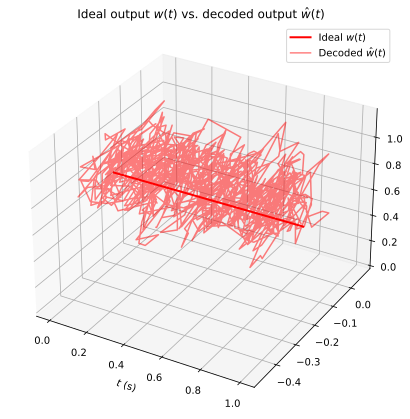

In [89]:
# Input signals
x_t = np.array([[0.5] * len(t), [1] * len(t)])
y_t = np.array([[0.1] * len(t), [0.3] * len(t)])
z_t = np.array([[0.2] * len(t), [0.1] * len(t)])
q_t =  np.array([[0.4] * len(t), [-0.2] * len(t)])
w_t = fx(x_t) + fy(y_t) + fz(z_t) + fq(q_t)

# Decode pop. x output
_, J_x = generate_2d_population_responses(x_t, a_max_x, xi_x, e_x, t_ref, t_RC, r=1)
spike_trains_x = np.zeros_like(J_x)

for i in range(n):
    _, t_spikes, _ = dv_dt(T, dt, J_x[i], v_th, t_ref, t_RC)
    spike_trains_x[i] = get_spike_trains(T, dt, t_spikes, [])[0]

A_fx = np.array([convolve(spike_train, h_t) for spike_train in spike_trains_x])
f_x_hat = D_fx.T @ A_fx

# Decode pop. y output
_, J_y = generate_2d_population_responses(y_t, a_max_y, xi_y, e_y, t_ref, t_RC, r=1)
spike_trains_y = np.zeros_like(J_y)

for i in range(n):
    _, t_spikes, _ = dv_dt(T, dt, J_y[i], v_th, t_ref, t_RC)
    spike_trains_y[i] = get_spike_trains(T, dt, t_spikes, [])[0]

A_fy = np.array([convolve(spike_train, h_t) for spike_train in spike_trains_y])
f_y_hat = D_fy.T @ A_fy

# Decode pop. z output
_, J_z = generate_2d_population_responses(z_t, a_max_z, xi_z, e_z, t_ref, t_RC, r=1)
spike_trains_z = np.zeros_like(J_z)

for i in range(n):
    _, t_spikes, _ = dv_dt(T, dt, J_z[i], v_th, t_ref, t_RC)
    spike_trains_z[i] = get_spike_trains(T, dt, t_spikes, [])[0]

A_fz = np.array([convolve(spike_train, h_t) for spike_train in spike_trains_z])
f_z_hat = D_fz.T @ A_fz

# Decpode pop. q output
_, J_q = generate_2d_population_responses(q_t, a_max_q, xi_q, e_q, t_ref, t_RC, r=1)
spike_trains_q = np.zeros_like(J_q)

for i in range(n):
    _, t_spikes, _ = dv_dt(T, dt, J_q[i], v_th, t_ref, t_RC)
    spike_trains_q[i] = get_spike_trains(T, dt, t_spikes, [])[0]

A_fq = np.array([convolve(spike_train, h_t) for spike_train in spike_trains_q])
f_q_hat = D_fq.T @ A_fq

# Sum decoded outputs for input to population w, decode output
w_input = f_x_hat + f_y_hat + f_z_hat + f_q_hat

_, J_w = generate_2d_population_responses(w_input, a_max_w, xi_w, e_w, t_ref, t_RC, r=1)
spike_trains_w = np.zeros_like(J_w)

for i in range(n):
    _, t_spikes, _ = dv_dt(T, dt, J_w[i], v_th, t_ref, t_RC)
    spike_trains_w[i] = get_spike_trains(T, dt, t_spikes, [])[0]

A_w = np.array([convolve(spike_train, h_t) for spike_train in spike_trains_w])
w_hat = D_w.T @ A_w

# Make 3D plot to compare
w_t_x, w_t_y = w_t[0], w_t[1]
w_hat_x, w_hat_y = w_hat[0], w_hat[1]

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.plot(t, w_t_x, w_t_y, label="Ideal $w(t)$", color="red", linewidth=2)
ax.plot(t, w_hat_x, w_hat_y, label="Decoded $\hat{w}(t)$", color="red", alpha=0.5)

ax.set_xlabel("$t$ (s)")
ax.set_title("Ideal output $w(t)$ vs. decoded output $\hat{w}(t)$")
ax.legend()
plt.show()

**b) Sinusoidal input.** Produce the same plot for
$$x =(0.5,1), \quad y = (\sin(4\pi t),0.3), \quad z =(0.2,0.1), \quad q = (\sin(4\pi t),-0.2) \,.$$


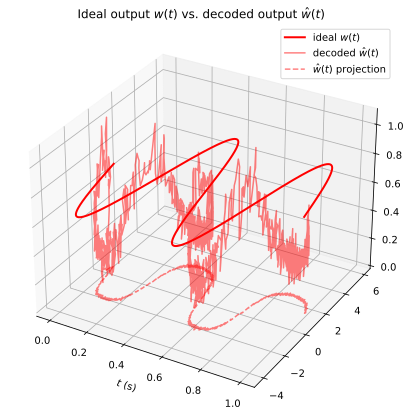

In [90]:
# Input signals
x_t = np.array([[0.5] * len(t), [1] * len(t)]) 
y_t = np.array([np.sin(4 * np.pi * t), [0.3] * len(t)])
z_t = np.array([[0.2] * len(t), [0.1] * len(t)])
q_t = np.array([np.sin(4 * np.pi * t), [-0.2] * len(t)])
w_t = fx(x_t) + fy(y_t) + fz(z_t) + fq(q_t)

# Decode pop. x output
_, J_x = generate_2d_population_responses(x_t, a_max_x, xi_x, e_x, t_ref, t_RC, r=1)
spike_trains_x = np.zeros_like(J_x)

for i in range(n):
    _, t_spikes, _ = dv_dt(T, dt, J_x[i], v_th, t_ref, t_RC)
    spike_trains_x[i] = get_spike_trains(T, dt, t_spikes, [])[0]

A_fx = np.array([convolve(spike_train, h_t) for spike_train in spike_trains_x])
f_x_hat = D_fx.T @ A_fx

# Decode pop. y output
_, J_y = generate_2d_population_responses(y_t, a_max_y, xi_y, e_y, t_ref, t_RC, r=1)
spike_trains_y = np.zeros_like(J_y)

for i in range(n):
    _, t_spikes, _ = dv_dt(T, dt, J_y[i], v_th, t_ref, t_RC)
    spike_trains_y[i] = get_spike_trains(T, dt, t_spikes, [])[0]

A_fy = np.array([convolve(spike_train, h_t) for spike_train in spike_trains_y])
f_y_hat = D_fy.T @ A_fy

# Decode pop. z output
_, J_z = generate_2d_population_responses(z_t, a_max_z, xi_z, e_z, t_ref, t_RC, r=1)
spike_trains_z = np.zeros_like(J_z)

for i in range(n):
    _, t_spikes, _ = dv_dt(T, dt, J_z[i], v_th, t_ref, t_RC)
    spike_trains_z[i] = get_spike_trains(T, dt, t_spikes, [])[0]

A_fz = np.array([convolve(spike_train, h_t) for spike_train in spike_trains_z])
f_z_hat = D_fz.T @ A_fz

# Decpode pop. q output
_, J_q = generate_2d_population_responses(q_t, a_max_q, xi_q, e_q, t_ref, t_RC, r=1)
spike_trains_q = np.zeros_like(J_q)

for i in range(n):
    _, t_spikes, _ = dv_dt(T, dt, J_q[i], v_th, t_ref, t_RC)
    spike_trains_q[i] = get_spike_trains(T, dt, t_spikes, [])[0]

A_fq = np.array([convolve(spike_train, h_t) for spike_train in spike_trains_q])
f_q_hat = D_fq.T @ A_fq

# Sum decoded outputs for input to population w, decode output
w_input = f_x_hat + f_y_hat + f_z_hat + f_q_hat

_, J_w = generate_2d_population_responses(w_input, a_max_w, xi_w, e_w, t_ref, t_RC, r=1)
spike_trains_w = np.zeros_like(J_w)

for i in range(n):
    _, t_spikes, _ = dv_dt(T, dt, J_w[i], v_th, t_ref, t_RC)
    spike_trains_w[i] = get_spike_trains(T, dt, t_spikes, [])[0]

A_w = np.array([convolve(spike_train, h_t) for spike_train in spike_trains_w])
w_hat = D_w.T @ A_w

# Make 3D plot to compare
w_t_x, w_t_y = w_t[0], w_t[1]
w_hat_x, w_hat_y = w_hat[0], w_hat[1]

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.plot(t, w_t_x, w_t_y, label="ideal $w(t)$", color="red", linewidth=2)
ax.plot(t, w_hat_x, w_hat_y, label="decoded $\hat{w}(t)$", color="red", alpha=0.5)

ax.plot(t, w_hat_x, [0] * len(t), color="red", linestyle="--", alpha=0.5, label='$\hat{w}(t)$ projection')

ax.set_xlabel("$t$ (s)")
ax.set_title("Ideal output $w(t)$ vs. decoded output $\hat{w}(t)$")
ax.legend()
plt.show()

**c) Discussion.** Describe your results and discuss why and how they stray from the expected answer.


We see results that are similar to Question 4, for similar reasons. The decoded output follows the ideal output, but with fluctuations. The way the axes are scaled, the fluctuation in the y-components is more obvious. The x-component projection is plotted to show that the decoded output does indeed follow the shape of the ideal output, but this component has fluctuations as well.

This time, we're decoding from multiple neuron populations. Computing each of the decoders with a finite number of neurons to cover the space already introduces some error. Then, the output of each population is decoded based on spikes, which, as before, introduces a lot of noise since a finite number of spikes is being used to approximate a continuous function. The input to population $w$ is a linear combination of these decoded outputs, and the output for $w$ is decoded with the same method, so overall, there are many sources of imperfection along the way.

One thing we notice is that for the sinusoidal decoded output, the amplitudes are slightly flattened. We might have flattened them with $h(t)$, especially if the neuron's responses by the time we got to population $w$ were not precise enough to capture these peaks. In general, with oscillatory or abruptly-changing functions, it can happen that we smooth out areas of sudden change.

For the linear function, we see lots of fluctuation for the same reasons, with the output still generally following the ideal output. The structure is a bit more consistent since the constant input does not change, so there aren't any precise details to approximate.
